# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check GPU
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(1))

2
NVIDIA GeForce RTX 3090


# Part C 

## Implement Custom Resnet + Batch Normalization

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_BN(nn.Module):
    def __init__(self):
        super(CustomResNet_BN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch Normalization
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.bn4(x)  # Apply Batch Normalization
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

## Load Dataset

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# # Data augmentation and normalization for training
# transform_train = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Optimizer and Train Setup

In [6]:
# Model, optimizer, and scheduler
model = CustomResNet_BN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [7]:
# Determine if CUDA is available and set the device accordingly
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomResNet_BN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64

In [8]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# Training loop with tracking of training and validation accuracies
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
best_val_accuracy = 0
best_model_weights = None


In [9]:
for epoch in range(1, 101):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer , criterion)
    val_loss, val_accuracy = test(model, device, val_loader , criterion)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_weights = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    scheduler.step()

Epoch: 1, Train Loss: 2.1024, Train Accuracy: 36.71%, Val Loss: 2.0392, Val Accuracy: 42.78%
Epoch: 2, Train Loss: 1.9552, Train Accuracy: 51.36%, Val Loss: 1.9874, Val Accuracy: 47.34%
Epoch: 3, Train Loss: 1.8800, Train Accuracy: 58.90%, Val Loss: 1.8805, Val Accuracy: 58.62%
Epoch: 4, Train Loss: 1.8312, Train Accuracy: 63.76%, Val Loss: 1.8556, Val Accuracy: 61.10%
Epoch: 5, Train Loss: 1.7974, Train Accuracy: 67.19%, Val Loss: 1.8317, Val Accuracy: 63.36%
Epoch: 6, Train Loss: 1.7761, Train Accuracy: 69.17%, Val Loss: 1.7986, Val Accuracy: 66.46%
Epoch: 7, Train Loss: 1.7582, Train Accuracy: 70.86%, Val Loss: 1.7959, Val Accuracy: 66.78%
Epoch: 8, Train Loss: 1.7379, Train Accuracy: 72.83%, Val Loss: 1.7675, Val Accuracy: 69.58%
Epoch: 9, Train Loss: 1.7257, Train Accuracy: 74.03%, Val Loss: 1.7642, Val Accuracy: 69.60%
Epoch: 10, Train Loss: 1.7180, Train Accuracy: 74.68%, Val Loss: 1.7488, Val Accuracy: 71.70%
Epoch: 11, Train Loss: 1.7075, Train Accuracy: 75.80%, Val Loss: 1.75

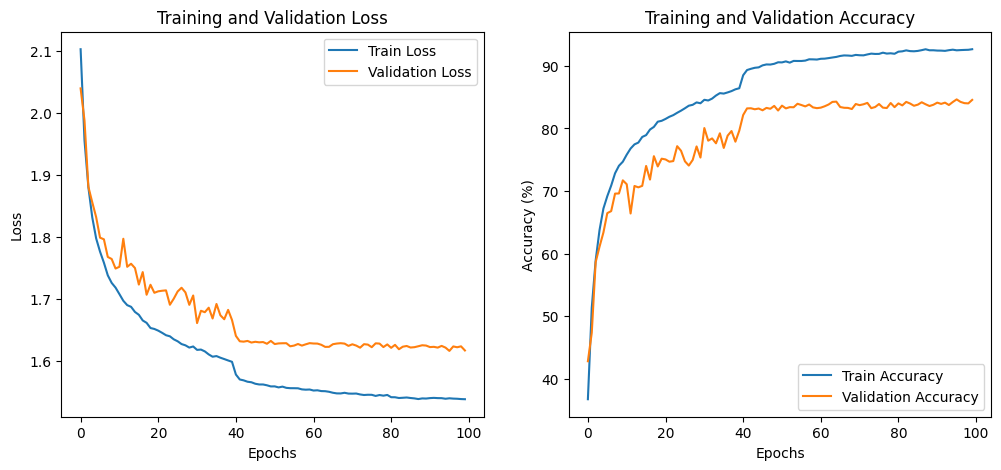

Best Validation Accuracy: 84.64%
Test Accuracy of the final model: 85.67%


In [10]:
# Load best model weights and evaluate on test set
model.load_state_dict(best_model_weights)
test_loss, test_accuracy = test(model, device, test_loader , criterion)

# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Print best validation accuracy and test accuracy
print(f'Best Validation Accuracy: {best_val_accuracy:.2f}%')
print(f'Test Accuracy of the final model: {test_accuracy:.2f}%')

# Save best model weights
torch.save(best_model_weights, 'best_custom_resnet_weights_BN.pth')

# Layer Wise analyse , Part A

In [ ]:
# download Pretrained Weight of model
import gdown
id = "1IJwVeL5zHiG0Yr29W8PdvCHnTZLU0fZH"
gdown.download(id=id, quiet=False)

In [ ]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

In [2]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [3]:
class CustomResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution
        self.elu = nn.ELU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # Batch Normalization after Convolution

    def forward(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x += shortcut
        x = self.elu(x)
        return x

class CustomResNet_BN(nn.Module):
    def __init__(self):
        super(CustomResNet_BN, self).__init__()
        # Initial convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch Normalization
        self.elu1 = nn.ELU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch Normalization
        self.elu2 = nn.ELU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Residual blocks
        self.resblock1 = CustomResNetBlock(64, 64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch Normalization
        self.elu3 = nn.ELU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch Normalization
        self.elu4 = nn.ELU()
        self.resblock2 = CustomResNetBlock(256, 256)
        
        # Average pooling and fully connected layers
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.elu1(x)
        x = self.conv2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = self.elu2(x)
        x = self.maxpool1(x)
        
        x = self.resblock1(x)
        x = self.conv3(x)
        x = self.bn3(x)  # Apply Batch Normalization
        x = self.elu3(x)
        x = self.maxpool2(x)
        
        x = self.conv4(x)
        x = self.bn4(x)  # Apply Batch Normalization
        x = self.elu4(x)
        x = self.maxpool3(x)
        x = self.resblock2(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [4]:
# Data augmentation and normalization
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Splitting train dataset into train and validation sets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Further split train_dataset into train_loader_dataset and 20% balanced subset
train_loader_dataset, _ = train_test_split(train_dataset.dataset, train_size=int(0.2 * len(train_dataset)),
                                           test_size=None, shuffle=True, stratify=train_dataset.dataset.targets)

# Data loaders
train_loader = DataLoader(train_loader_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Instantiate and load the model
model = CustomResNet_BN()  # Make sure CustomResNet is defined as earlier
model.load_state_dict(torch.load('best_custom_resnet_weights_BN.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

CustomResNet_BN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu1): ELU(alpha=1.0)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu2): ELU(alpha=1.0)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (resblock1): CustomResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {''}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

## SI and CenterSI layer for Train Loader

In [9]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 69.29it/s]


### Calc SI

In [10]:
si_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_train.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 371.73it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6370.45it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7264.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7495.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7101.77it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6434.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7667.83it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7560.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7407.81it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7781.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7710.12it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7684.69it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6978.88it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7940.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7449.92it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8109.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7389.54it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7473.81it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7727.16it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7219.11it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7118.64it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7549.14it/s]


In [11]:
si_layer_train

[('conv1', 0.22411110997200012),
 ('bn1', 0.22411110997200012),
 ('elu1', 0.22555555403232574),
 ('conv2', 0.21422222256660461),
 ('bn2', 0.21422222256660461),
 ('elu2', 0.20711112022399902),
 ('maxpool1', 0.30666667222976685),
 ('resblock1', 0.4112222194671631),
 ('maxpool2', 0.4842222332954407),
 ('conv3', 0.4314444363117218),
 ('bn3', 0.4314444363117218),
 ('elu3', 0.4404444396495819),
 ('maxpool3', 0.6294444799423218),
 ('conv4', 0.5782222151756287),
 ('bn4', 0.5782222151756287),
 ('elu4', 0.59333336353302),
 ('resblock2', 0.8196666836738586),
 ('avgpool', 0.8838889002799988),
 ('flatten', 0.8838889002799988),
 ('fc1', 0.8877778053283691),
 ('fc2', 0.8836666941642761),
 ('softmax', 0.9116666913032532)]

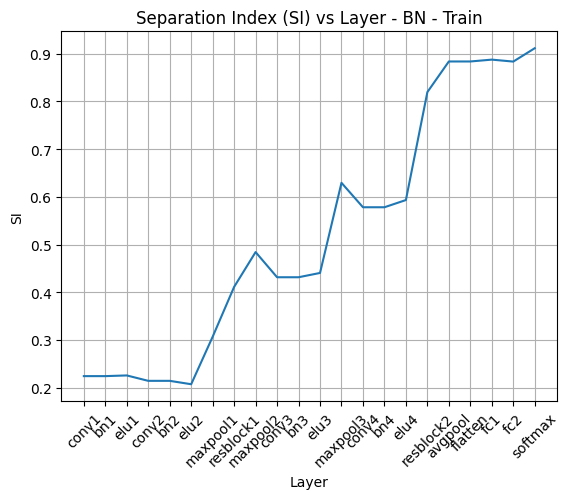

In [12]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_train], [si for _, si in si_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - BN - Train')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center Si

In [13]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 728.28it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4374.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4516.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4201.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4502.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4432.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2988.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3085.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3999.91it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4312.47it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4513.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4403.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3981.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3240.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3291.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3155.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4320.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2009.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2857.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3396.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4289.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4395.62it/s]


[('conv1', 0.3494444489479065), ('bn1', 0.3494444489479065), ('elu1', 0.3655555546283722), ('conv2', 0.38011112809181213), ('bn2', 0.38011112809181213), ('elu2', 0.3878888785839081), ('maxpool1', 0.45822224020957947), ('resblock1', 0.5777778029441833), ('maxpool2', 0.6150000095367432), ('conv3', 0.5846666693687439), ('bn3', 0.5846666693687439), ('elu3', 0.5872222185134888), ('maxpool3', 0.660444438457489), ('conv4', 0.6196666955947876), ('bn4', 0.6196666955947876), ('elu4', 0.624666690826416), ('resblock2', 0.9008889198303223), ('avgpool', 0.9264444708824158), ('flatten', 0.9264444708824158), ('fc1', 0.9281111359596252), ('fc2', 0.9005555510520935), ('softmax', 0.9378889203071594)]


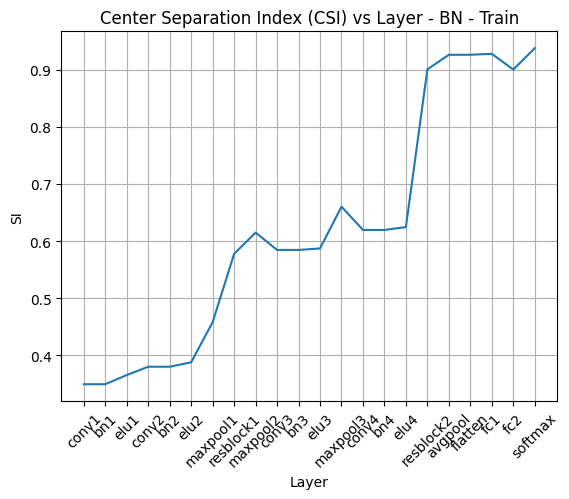

In [14]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - BN - Train')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Val Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(val_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


### Calc SI

In [9]:
si_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_val.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 218.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4622.67it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4934.48it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5142.18it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5552.92it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5159.05it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5249.44it/s]

Data has been normalized



Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5442.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4788.02it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5280.28it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5071.71it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5535.82it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4511.62it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5363.56it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5435.38it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5029.14it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4689.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4609.13it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4585.61it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4545.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 4832.15it/s]


Data has been normalized


Calculating SI: 100%|██████████| 3/3 [00:00<00:00, 5307.01it/s]


In [10]:
si_layer_val

[('conv1', 0.21660000085830688),
 ('bn1', 0.21660000085830688),
 ('elu1', 0.22100000083446503),
 ('conv2', 0.210999995470047),
 ('bn2', 0.210999995470047),
 ('elu2', 0.21220000088214874),
 ('maxpool1', 0.2913999855518341),
 ('resblock1', 0.36419999599456787),
 ('maxpool2', 0.44739997386932373),
 ('conv3', 0.3959999978542328),
 ('bn3', 0.3959999978542328),
 ('elu3', 0.41040000319480896),
 ('maxpool3', 0.5885999798774719),
 ('conv4', 0.5375999808311462),
 ('bn4', 0.5375999808311462),
 ('elu4', 0.5568000078201294),
 ('resblock2', 0.8113999962806702),
 ('avgpool', 0.8833999633789062),
 ('flatten', 0.8833999633789062),
 ('fc1', 0.8871999979019165),
 ('fc2', 0.8841999769210815),
 ('softmax', 0.9143999814987183)]

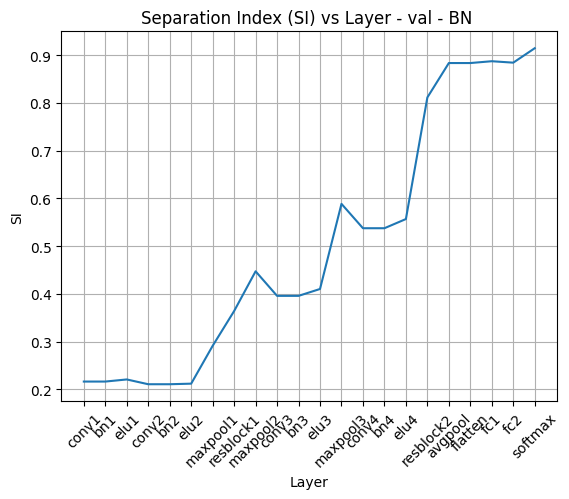

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_val], [si for _, si in si_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - val - BN ')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### calc Center SI

In [12]:
csi_layer_val = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_val.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 432.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3195.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3337.64it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2980.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3109.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3434.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2989.53it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3152.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3013.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3192.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3485.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3366.22it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2901.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3558.52it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3233.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3306.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3264.05it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1953.26it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2403.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2353.71it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3431.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3125.41it/s]


[('conv1', 0.3659999966621399), ('bn1', 0.3659999966621399), ('elu1', 0.38019999861717224), ('conv2', 0.3901999890804291), ('bn2', 0.3901999890804291), ('elu2', 0.40119999647140503), ('maxpool1', 0.46539998054504395), ('resblock1', 0.5848000049591064), ('maxpool2', 0.6186000108718872), ('conv3', 0.5821999907493591), ('bn3', 0.5821999907493591), ('elu3', 0.587399959564209), ('maxpool3', 0.6645999550819397), ('conv4', 0.6227999925613403), ('bn4', 0.6227999925613403), ('elu4', 0.6305999755859375), ('resblock2', 0.9041999578475952), ('avgpool', 0.9293999671936035), ('flatten', 0.9293999671936035), ('fc1', 0.9321999549865723), ('fc2', 0.9061999917030334), ('softmax', 0.943399965763092)]


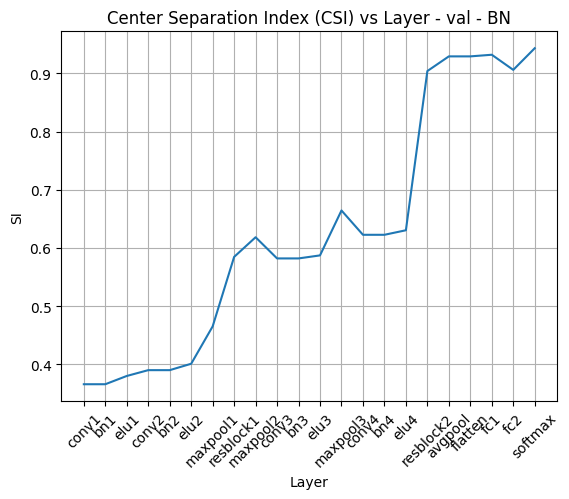

In [13]:
print(csi_layer_val)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_val], [si for _, si in csi_layer_val])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - val - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## SI and CenterSI layer for Test Loader

In [8]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        # Flatten and concatenate the features for each layer
        features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
    else:
        print(f"No features captured for layer {layer_name}")

# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 40/40 [00:01<00:00, 26.96it/s]


### Calc SI

In [9]:
si_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    si = instance_disturbance.si_batch(batch_size=2000)
    si_layer_test.append((layer_name, si))

Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 368.10it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7394.75it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7159.96it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7790.31it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8246.76it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7901.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8131.65it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7980.03it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7901.85it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7457.87it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7857.44it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6378.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 8298.98it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7662.23it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7687.51it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7508.60it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 6887.20it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 5556.84it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7384.34it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7004.52it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7463.17it/s]


Data has been normalized


Calculating SI: 100%|██████████| 5/5 [00:00<00:00, 7224.09it/s]


In [10]:
si_layer_test

[('conv1', 0.2223999947309494),
 ('bn1', 0.2223999947309494),
 ('elu1', 0.22119998931884766),
 ('conv2', 0.21529999375343323),
 ('bn2', 0.21529999375343323),
 ('elu2', 0.2141999900341034),
 ('maxpool1', 0.2938999831676483),
 ('resblock1', 0.3933999836444855),
 ('maxpool2', 0.4730999767780304),
 ('conv3', 0.4220999777317047),
 ('bn3', 0.4220999777317047),
 ('elu3', 0.43359997868537903),
 ('maxpool3', 0.602899968624115),
 ('conv4', 0.5584999918937683),
 ('bn4', 0.5584999918937683),
 ('elu4', 0.5776999592781067),
 ('resblock2', 0.7633999586105347),
 ('avgpool', 0.7883999943733215),
 ('flatten', 0.7883999943733215),
 ('fc1', 0.7852999567985535),
 ('fc2', 0.7807999849319458),
 ('softmax', 0.8100000023841858)]

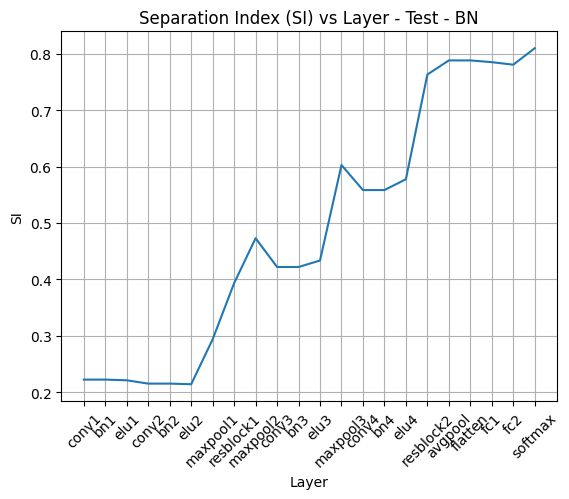

In [11]:
# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in si_layer_test], [si for _, si in si_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Separation Index (SI) vs Layer - Test - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Calc Center SI

In [12]:
csi_layer_test = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_test.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 755.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4396.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4609.13it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4492.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4095.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4287.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3187.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3386.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4206.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4572.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4509.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4750.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4362.70it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3036.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3303.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3558.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4582.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4162.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4558.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4403.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4465.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4719.06it/s]


[('conv1', 0.3554999828338623), ('bn1', 0.3554999828338623), ('elu1', 0.36980000138282776), ('conv2', 0.3804999887943268), ('bn2', 0.3804999887943268), ('elu2', 0.3862999975681305), ('maxpool1', 0.45319998264312744), ('resblock1', 0.5644999742507935), ('maxpool2', 0.6032999753952026), ('conv3', 0.5697999596595764), ('bn3', 0.5697999596595764), ('elu3', 0.5742999911308289), ('maxpool3', 0.6448000073432922), ('conv4', 0.612500011920929), ('bn4', 0.612500011920929), ('elu4', 0.6197999715805054), ('resblock2', 0.8276999592781067), ('avgpool', 0.8454999923706055), ('flatten', 0.8454999923706055), ('fc1', 0.8458999991416931), ('fc2', 0.8234999775886536), ('softmax', 0.8567999601364136)]


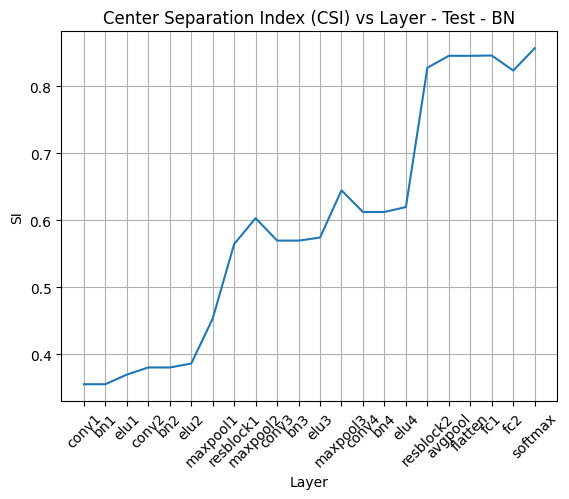

In [13]:
print(csi_layer_test)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_test], [si for _, si in csi_layer_test])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer - Test - BN')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()